In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as pd
from pygem_eb.processing.plotting_fxns import *
from objectives import *
import os

In [27]:
site_profiles = {'A':[],'B':[],'D':[]}
for site in site_profiles:
    fp = '../MB_data/Point/gulkana/pitcore/'
    files = os.listdir(fp)
    profiles = {'sbd':{},'density':{}}
    for f in files:
        s = f.split('_')[-1].split('.')[0]
        if s == site and 'Pit' in f:
            if '_04' in f or '.04' in f:
                year = f[8:12]
                if year[-1] == '.':
                    year = f[7:11]
                year = int(year)
                df = pd.read_csv(fp + f)
                if len(df['sample_bottom_depth']) > 2:
                    profiles['sbd'][year] = df['sample_bottom_depth'].to_numpy() /100
                    density = df['sample_weight'] / df['volume'] * 1000
                    profiles['density'][year] = density.to_numpy()
    site_profiles[site] = profiles

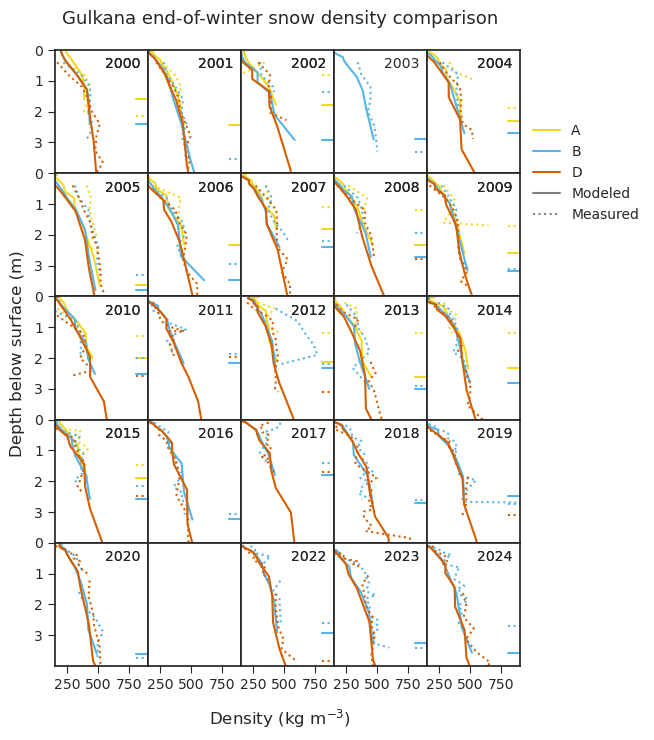

In [31]:
years = np.arange(2000,2025)
fig,axes = plt.subplots(5,5,figsize=(6,8),sharex=True,sharey=True,gridspec_kw={'hspace':0,'wspace':0})
axes = axes.flatten()
norm = mpl.colors.Normalize(vmin=0,vmax=4)
# cmap = mpl.colormaps.get_cmap('viridis')
colors = ['#F4D81C','#56B4E9','#D55E00']
for ss,site in enumerate(site_profiles):
    # color = cmap(norm(ss))
    color = colors[ss]
    ds,s,e =  getds(f'../Output/EB/11_04/Gulkana_2024_11_04_long{site}_2.nc')
    # ds = dsdict[site]['0-2']['0.018']['3']
    profiles = site_profiles[site]
    for y,year in enumerate(years):
        ax = axes[y]
        if year in profiles['sbd']:
            dsyear = ds.sel(time=pd.to_datetime(f'{year}-04-20'))
            lheight = dsyear.layerheight.values
            ldepth = np.array([np.sum(lheight[:i+1])-(lheight[i]/2) for i in range(len(lheight))])
            ldensity = dsyear['layerdensity'].values
            interp_density = np.interp(profiles['sbd'][year],ldepth,ldensity)
            diff = profiles['density'][year] - interp_density
            # ax.plot(diff,profiles['sbd'][year],color=cmap(norm(ss)))
            ax.set_title('')
            ax.text(550,0.6,str(year),fontsize=10)
            snow_idx = np.where(ldensity < 750)[0]

            # plot_meas_density = np.append(profiles['density'][year],900)
            # plot_meas_depth = np.append(profiles['sbd'][year],profiles['sbd'][year][-1])
            # plot_model_density = np.append(ldensity[snow_idx],900)
            # plot_model_depth = np.append(ldepth[snow_idx],ldepth[snow_idx[-1]])
            plot_meas_density = profiles['density'][year]
            plot_meas_depth = profiles['sbd'][year]
            plot_model_density = ldensity[snow_idx]
            plot_model_depth = ldepth[snow_idx]

            ax.plot(plot_model_density,plot_model_depth,color=color)
            ax.plot(plot_meas_density,plot_meas_depth,color=color,linestyle=':')
            snowdepth_mod = ldepth[snow_idx[-1]]
            snowdepth_pit = profiles['sbd'][year][-1]
            ax.plot([800,900],[snowdepth_mod,snowdepth_mod],color=color)
            ax.plot([800,900],[snowdepth_pit,snowdepth_pit],color=color,linestyle=':')
    axes[4].plot(np.nan,np.nan,label=site,color=color)
axes[4].plot(np.nan,np.nan,label='Modeled',color='grey')
axes[4].plot(np.nan,np.nan,label='Measured',linestyle=':',color='grey')
for a,ax in enumerate(axes):
    ax.invert_yaxis()
    ax.set_ylim(4,0)
    ax.set_yticks([0,1,2,3])
    ax.tick_params(length=5,labelsize=10)
    # ax.set_xlim(-350,350)
    if a % 5 != 0:
        ax.tick_params('y',length=0)
    ax.set_xlim(150,900)
    ax.set_xticks([250,500,750])
    ax.axvline(0,linewidth=0.5,color='black')
fig.supxlabel('Density (kg m$^{-3}$)',fontsize=12,y=0.03)
fig.supylabel('Depth below surface (m)',fontsize=12,x=0.05)
# axes[0].legend(bbox_to_anchor=(5.6,0.65))
axes[4].legend(bbox_to_anchor=(1,0.5))
fig.suptitle(f'Gulkana end-of-winter snow density comparison',fontsize=13,y=0.93)
# plt.show()
plt.savefig(f'../Output/EB/gulkana_pits_modeled.png',dpi=220,bbox_inches='tight')

Text(0.5, 0.98, '')

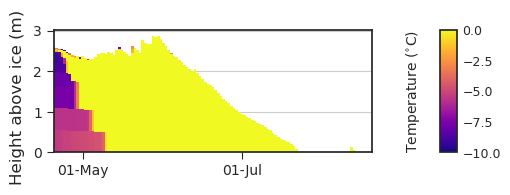

In [35]:
fig,ax = visualize_layers(bds,pd.date_range('2024-04-20','2024-08-20'),['layertemp'])
fig.suptitle('')

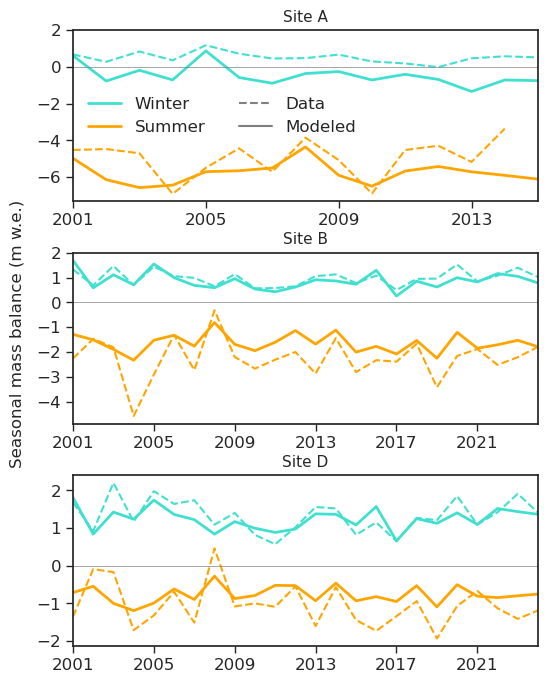

In [12]:
fig, axes = plt.subplots(3,figsize=(6,8),gridspec_kw={'hspace':0.3})
for ss,site in enumerate(['A','B','D']):
    try:
        ads,s,e = getds(f'../Output/EB/11_04/Gulkana_2024_11_04_long{site}_2.nc')
    except:
        # ads,s,e = getds(f'../Output/EB/11_04/Gulkana_2024_11_04_long{site}_1.nc')
        continue
        # ads
    axes[ss] = seasonal_mass_balance(site,ads,plot=True,plot_ax=axes[ss])
    axes[ss].set_ylabel('')
    axes[ss].set_title(f'Site {site}',fontsize=11)
    if ss != 0:
        axes[ss].get_legend().remove()
    else:
        axes[ss].set_yticks([-6,-4,-2,0,2])
    # fig,ax = visualize_layers(ads,pd.date_range(s,s+pd.Timedelta(days=365)),['layerdensity'])
fig.supylabel('Seasonal mass balance (m w.e.)',fontsize=12)
# plt.show()
plt.savefig('../Output/EB/longrun_11_04.png',dpi=180,bbox_inches='tight')
    # assert 1==0

Compare albedo

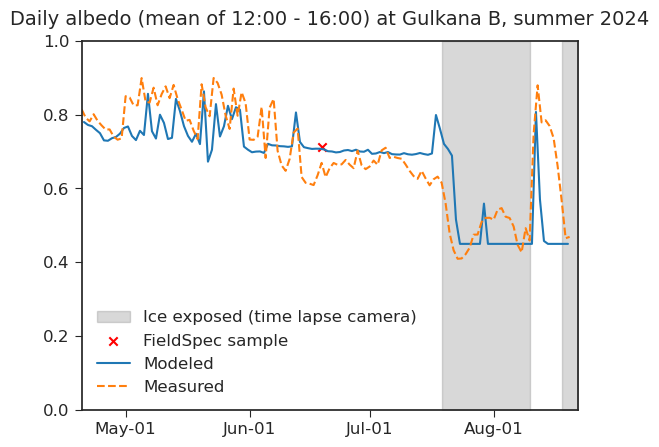

In [25]:
df = pd.read_csv('/home/claire/research/climate_data/AWS/Preprocessed/CLAWS_2024_allvars.csv',index_col=0)
df.index = pd.to_datetime(df.index) # - pd.Timedelta(hours=8)
# df['albedo'] = df['SWout'] / df['SWin']
daily_albedo = []
dates = pd.date_range('2024-04-20','2024-08-22',freq='d')
for date in dates:
    start = pd.to_datetime(str(date.date())+' 12:00')
    end = pd.to_datetime(str(date.date())+' 16:00')
    # print(df.loc[start:end,'albedo'].values)
    daily_albedo.append(np.mean(df.loc[start:end,'albedo']))
y = np.arange(0,1.1,0.1)
fig,ax = plt.subplots()
ax.fill_betweenx(y,[pd.to_datetime('2024-07-19')],[pd.to_datetime('2024-08-10')],color='grey',alpha=0.3,label='Ice exposed (time lapse camera)')
ax.fill_betweenx(y,[pd.to_datetime('2024-08-18')],[pd.to_datetime('2024-08-22')],color='grey',alpha=0.3)
ax.scatter(pd.to_datetime('2024-06-19'),0.7123,marker='x',color='red',label='FieldSpec sample')
ax.set_xlim(dates[0],dates[-1])
ax.set_ylim(0,1)
ax.tick_params(labelsize=12)
ax.set_xticks(pd.date_range(dates[0],dates[-1],freq='MS'))
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b-%d'))
ax.set_title('Daily albedo (mean of 12:00 - 16:00) at Gulkana B, summer 2024',fontsize=14,y=1.02)
plt.tick_params(size=5)
dsp = bds.sel(time=pd.date_range('2024-04-20 14:00','2024-08-19 14:00'))
ax.plot(dsp.time,dsp['albedo'],label='Modeled')
ax.plot(dates,daily_albedo,label='Measured',linestyle='--')
ax.legend(fontsize=12)
# plt.show()
plt.savefig('/home/claire/research/Output/EB/albedo_modeled_11_05.png',dpi=150,bbox_inches='tight')


Site B internal acc: 0.00011 m w.e.
Site B internal acc: 0.00011 m w.e.
Site D internal acc: 0.14696 m w.e.
Site D internal acc: 0.14696 m w.e.
Site T internal acc: 0.15798 m w.e.
Site T internal acc: 0.15798 m w.e.


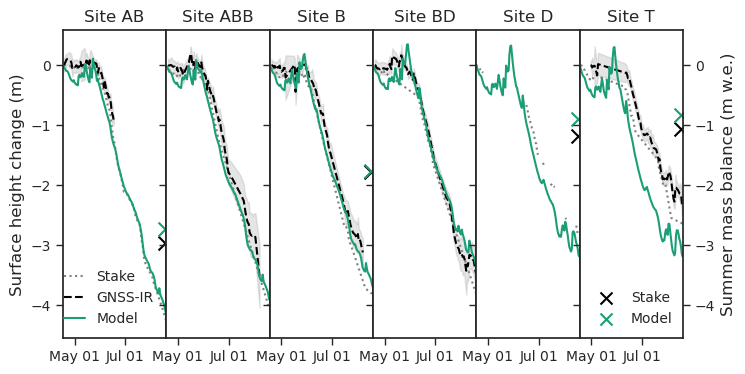

In [4]:
id = 3 # Best on 10/31: 7 (kp=2)
fig,axes = plt.subplots(1,6,figsize=(8,4),sharey=True,sharex=True,gridspec_kw={'wspace':0})
for i,site in enumerate(['AB','ABB','B','BD','D','T']):
    ds,startdate,enddate = getds(f'../Output/EB/Gulkana_11_06_2024{site}_{id}.nc')
    if site == 'B':
        bds = ds.copy(deep=True)
    axes[i],error = cumulative_mass_balance(site,ds,plot=True,plot_ax=axes[i])
    axes[i].set_title(f'Site {site}',fontsize=12)
    axes[i].set_ylabel('')
    # direction = '' if error < 0 else '+'
    # text = f'{direction}{error:.3f} m'
    # axes[i].text(enddate-pd.Timedelta(days=80),0.9,text,fontsize=10)
    axes[i].get_legend().remove()
    axes[i].set_xlim(startdate,enddate)
    axes[i].set_xticks(pd.date_range(startdate,enddate,freq='2MS'))
    axes[i].tick_params(labelsize=10)
    if site not in ['ABB','BD']:
        mbmod,mbmeas = cumulative_mass_balance(site,ds)
        axes[i].scatter(enddate-pd.Timedelta(days=2),mbmeas,color='black',marker='x',s=100)
        axes[i].scatter(enddate-pd.Timedelta(days=2),mbmod,color=plt.cm.Dark2(0),marker='x',s=100)
axes[-1].set_ylabel('Summer mass balance (m w.e.)',fontsize=12)
axes[-1].yaxis.set_label_position('right')
axes[-1].yaxis.set_ticks_position('both')
axes[-1].tick_params(labelright=True)
axes[0].set_ylabel('Surface height change (m)',fontsize=12)
mod = axes[-1].scatter(np.nan,np.nan,color=plt.cm.Dark2(0),marker='x',s=75)
meas = axes[-1].scatter(np.nan,np.nan,color='black',marker='x',s=75)
axes[-1].legend([meas,mod],['Stake','Model'],facecolor='white',fontsize=10)
axes[0].legend(facecolor='white',fontsize=10,handlelength=1.5)


# plt.savefig(f'/home/claire/research/Output/EB/gulkana_dh_11_04.png',dpi=180,bbox_inches='tight')
plt.show()

ACTUAL CALIBRATION

In [17]:
dsdict = {'A':{},'B':{},'D':{}}
# params = {'T_threshold':[[0,1],[0,2],[1.2,3.2]],
#           'Boone_c5':[0.018,0.05],
#           'kp':[1,3]}
params = {'T_threshold':[[0,1],[0,2],[1.2,3.2]],
          'Boone_c5':[0.018,0.05]}
for site in dsdict:
    for threshold in params['T_threshold']:
        threshold = str(threshold[0])+'-'+str(threshold[1])
        dsdict[site][threshold] = {}
        for c5 in params['Boone_c5']:
            c5 = str(np.round(c5,3))
            dsdict[site][threshold][c5] = {}
            # for kp in params['kp']:
            #     kp = str(int(kp))
            # dsdict[site][threshold][c5][kp] = []

In [23]:
# FIND BEST RUN IN A SET
date = '11_04'
path_out = f'/home/claire/research/Output/EB/{date}/'
sites= ['A','B','D']
# fn = f'kw{kw}_ksnow{k_snow}_aice{a_ice}_site{site}_0.nc'

for site in sites:
    for i in range(18):
        fn = f'gridsearch_{date}_{site}_set{i}_run0_0.nc'
        try:
            ds,startdate,enddate = getds(path_out+fn)
        except:
            # print(fn,'doesnt exist')
            continue
        winter,summer = seasonal_mass_balance(site,ds)
        kp = ds.attrs['kp']
        c5 = ds.attrs['c5']
        threshold = ds.attrs['threshold_low']+'-'+ds.attrs['threshold_high']
        dsdict[site][threshold][c5] = ds
    # if i % 5 == 0:
    #     print(ds.attrs[param])
    # outdict[site].append(np.mean([winter,summer]))
    # print(ds.attrs['k_snow'],winter,summer,np.mean([winter,summer]))
# best = {}
# for site in sites:
#     best[site] = dsdict[site][np.argmin(outdict[site])]
#     print(site,np.argmin(outdict[site]))
    # simple_plot(ds,['2004-04-20','2004-10-20'],[['albedo']],res='d')

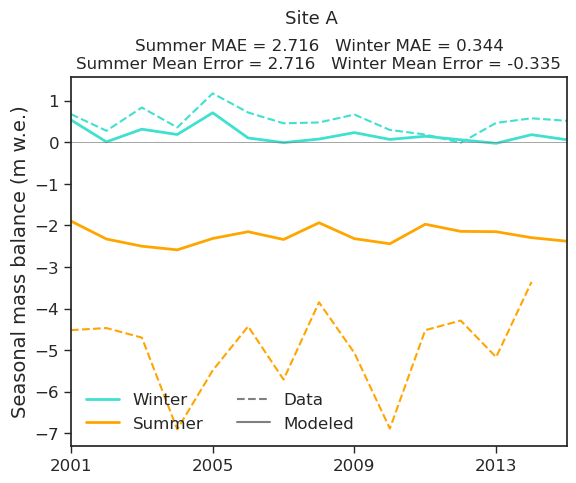

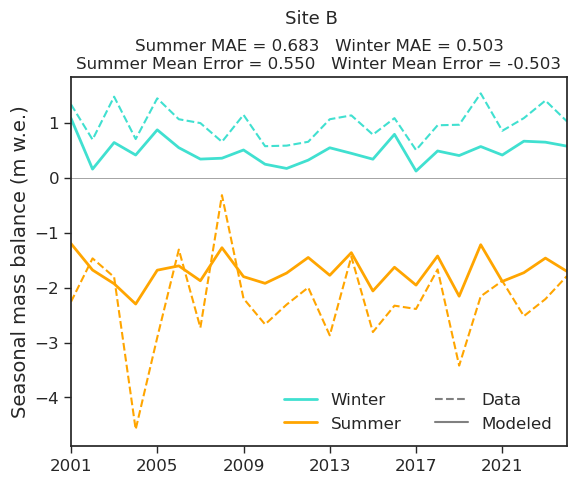

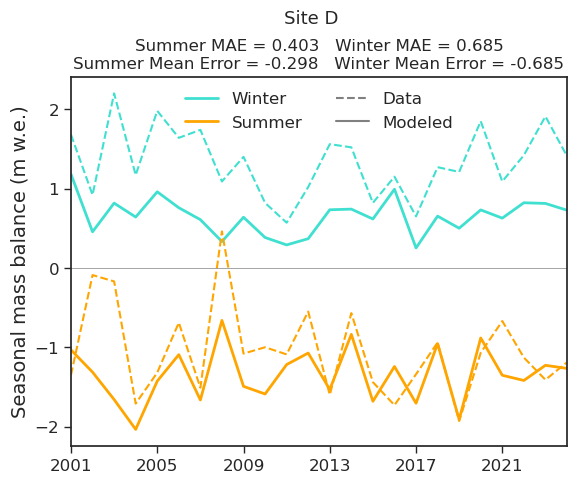

In [26]:
for site in ['A','B','D']:
    ds = dsdict[site]['0-1']['0.05']
    fig,ax = seasonal_mass_balance(site,ds,plot=True)
    fig.suptitle(f'Site {site}',y=1.02,fontsize=13)

In [6]:
result_df = pd.DataFrame(data=np.zeros((len(sites),3)),columns=sites,index=['kp','kw','a_ice'])
for site in sites:
    ds = best[site]
    result_df.loc['kp',site] = float(ds.attrs['kp'])
    if site == 'D':
        result_df.loc['kw',site] = 2 #float(ds.attrs['kw'])
        result_df.loc['a_ice',site] = 0.4
    else:
        result_df.loc['a_ice',site] = float(ds.attrs['a_ice'])
        result_df.loc['kw',site] = 3
# result_df.to_csv(f'/home/claire/research/Gulkana_params_{date}_HIGHWIND.csv',sep=',')
print(result_df)

         AB    B    D
kp     3.20  3.2  3.2
kw     3.00  3.0  2.0
a_ice  0.25  0.4  0.4


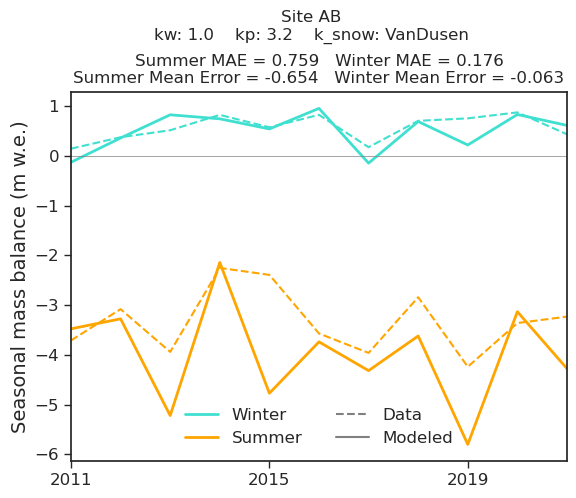

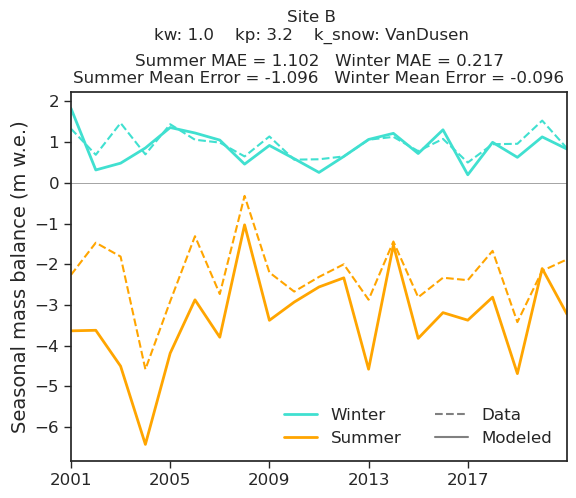

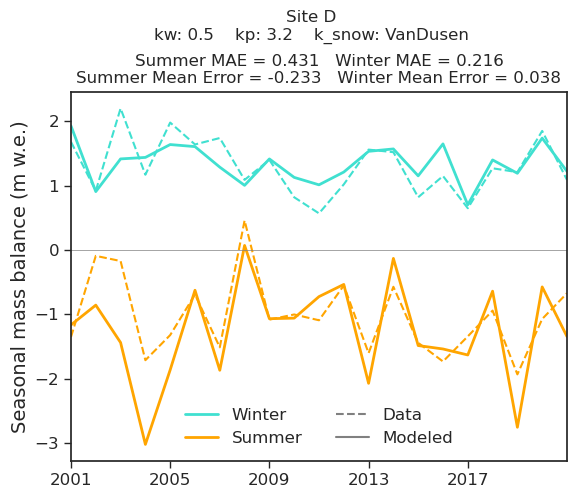

In [3]:
for site in sites:
    # ds = best[site]
    ds = dsdict[site][-1]
    # ds = xr.open_dataset(f'/home/claire/research/Output/EB/Gulkana_10_09_paramset_{site}_0.nc')
    param = 'kw' #if site == 'D' else 'a_ice'
    k_snow = ds.attrs['k_snow']
    kw = ds.attrs['kw']
    a_ice = ds.attrs['a_ice']
    kp = ds.attrs['kp']
    # kp = result_df.loc['kp',site]
    # kw = result_df.loc['kw',site]
    # a_ice = result_df.loc['a_ice',site]
    param_value = kw if param == 'kw' else a_ice # float(ds.attrs[param])
    fig,ax = seasonal_mass_balance(data_fp,ds,site,plot=True)
    fig.suptitle(f'Site {site}\n{param}: {param_value}    kp: {kp}    k_snow: {k_snow}',y=1.05)
    # plt.savefig(f'/home/claire/research/Output/calibration/{date}_paramsMERRA2_{site}.png',dpi=200,bbox_inches='tight')

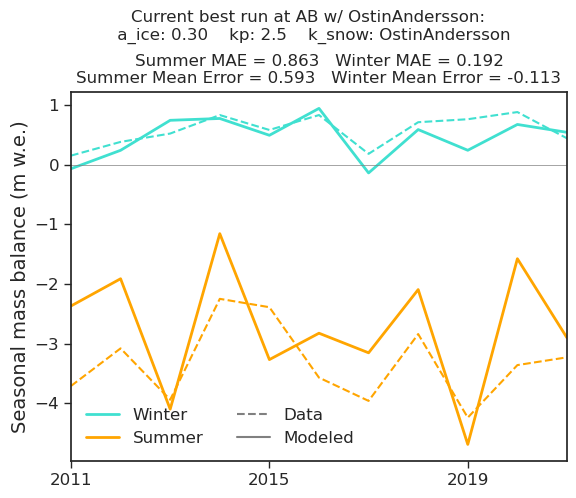

In [45]:
k_snow = ds.attrs['k_snow']
kw = ds.attrs['kw']
a_ice = ds.attrs['a_ice']
kp = ds.attrs['kp']
param_value = float(ds.attrs[param])
fig,ax = seasonal_mass_balance(data_fp,ds,site,plot=True)
fig.suptitle(f'Current best run at {site}: \n {param}: {param_value:.2f}    kp: {kp}    k_snow: {k_snow}',y=1.05)
# plt.show()
# plt.savefig(f'/home/claire/research/Output/calibration/10_05_0/best_{site}.png',dpi=200,bbox_inches='tight')

In [234]:
path_out = '/home/claire/research/Output/calibration/09_24/'

# Parameter sets
aa = [0.2,0.4,0.6]
ww = [0.25,0.5,0.75,1]
kk = ['Sturm','Douville','Jansson'] #,'OstinAndersson','VanDusen']
params_dict = {'kw':ww,'k_snow':kk,'a_ice':aa} # 'kw':ww,

# Get the lengths of each parameter list for the result array shape
shape = [len(v) for v in params_dict.values()]

# Initialize result arrays with a dimension for site (3 sites + 1 for the average)
winter_result = np.ones([4] + shape)
summer_result = np.ones([4] + shape)

# Initialize lists for storing the parameters
params_list = {key: [] for key in params_dict}

# Generate combinations of all parameters
all_combos = itertools.product(*params_dict.values())
for idx, param_values in enumerate(all_combos):
    # Unpack indices
    indices = np.unravel_index(idx, shape)

    # Store parameter set
    for param_name, param_value in zip(params_dict.keys(), param_values):
        params_list[param_name].append(param_value)
    
    # Iterate over sites
    for s, site in enumerate(['AB', 'B', 'D']):
        kw = 0.25 if site == 'D' else 1
        fn = f'kw{kw}_'

        # fn = ''
        for param_name, param_value in zip(params_dict.keys(), param_values):
            fn += param_name.replace('_','')+str(param_value)+'_'
        fn += f'site{site}_0.nc'

        try:
            ds, startdate, enddate = getds(path_out + fn)
            winter, summer = seasonal_mass_balance(data_fp, ds, site=site, method='MAE')
        except:
            winter, summer = (np.nan, np.nan)
            print(fn + ' does not exist')
        
        # Store results in the corresponding array
        winter_result[s][indices] = winter
        summer_result[s][indices] = summer

    # Compute site averages and store in the last index (3rd index in the result arrays)
    winter_result[3][indices] = np.mean(winter_result[:3,*indices])
    summer_result[3][indices] = np.mean(summer_result[:3,*indices])

In [235]:
best = {'winter': {key: [] for key in params_dict}, 
        'summer': {key: [] for key in params_dict}}

if summer_result.shape == (4,4,3,3):
    print('When including kw as a parameter:')
elif summer_result.shape == (4,3,3):
    print('When setting kw = 0.25 at site D, 1 elsewhere:')
for site in ['mean','AB','B','D','mean']:
    idx = np.where(np.array(['AB','B','D','mean']) == site)[0]
    best_winter = np.argmin(winter_result[idx])
    best_summer = np.argmin(summer_result[idx])
    for key in params_dict:
        best['winter'][key] = params_list[key][best_winter]
        best['summer'][key] = params_list[key][best_summer]
    if site == 'mean':
        print('Best winter parameter set overall:',best['winter'])
        print('Best summer parameter set overall:',best['summer'])
        print()
    else:
        print(f'Best winter parameter set at site {site}:',best['winter'])
        print(f'Best summer parameter set at site {site}:',best['summer'])

When setting kw = 0.25 at site D, 1 elsewhere:
Best winter parameter set overall: {'k_snow': 'Sturm', 'a_ice': 0.6}
Best summer parameter set overall: {'k_snow': 'Jansson', 'a_ice': 0.6}

Best winter parameter set at site AB: {'k_snow': 'Jansson', 'a_ice': 0.4}
Best summer parameter set at site AB: {'k_snow': 'Jansson', 'a_ice': 0.2}
Best winter parameter set at site B: {'k_snow': 'Sturm', 'a_ice': 0.6}
Best summer parameter set at site B: {'k_snow': 'Jansson', 'a_ice': 0.6}
Best winter parameter set at site D: {'k_snow': 'Sturm', 'a_ice': 0.6}
Best summer parameter set at site D: {'k_snow': 'Sturm', 'a_ice': 0.2}
Best winter parameter set overall: {'k_snow': 'Sturm', 'a_ice': 0.6}
Best summer parameter set overall: {'k_snow': 'Jansson', 'a_ice': 0.6}



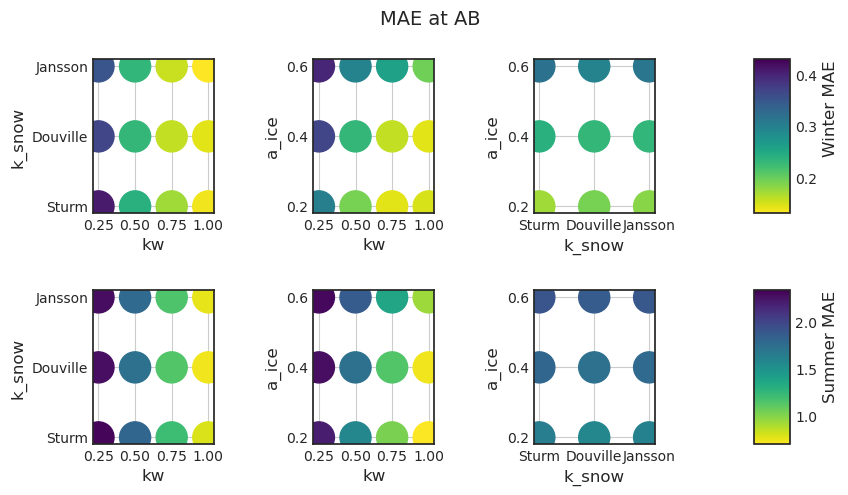

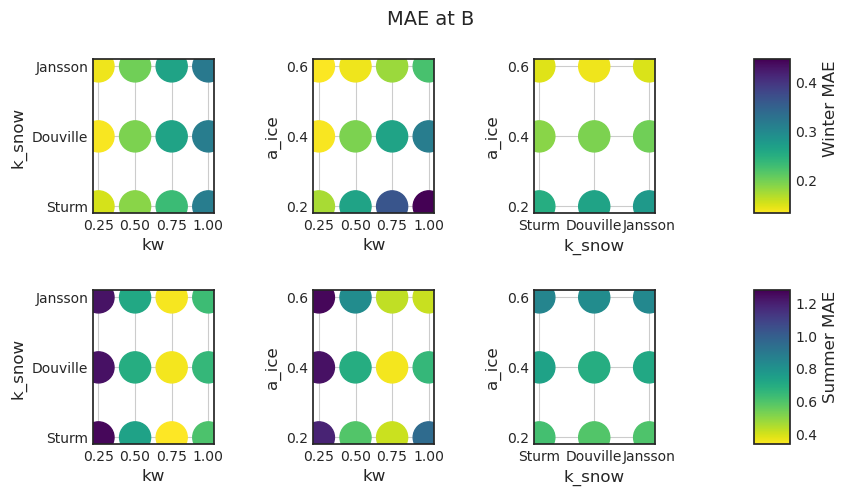

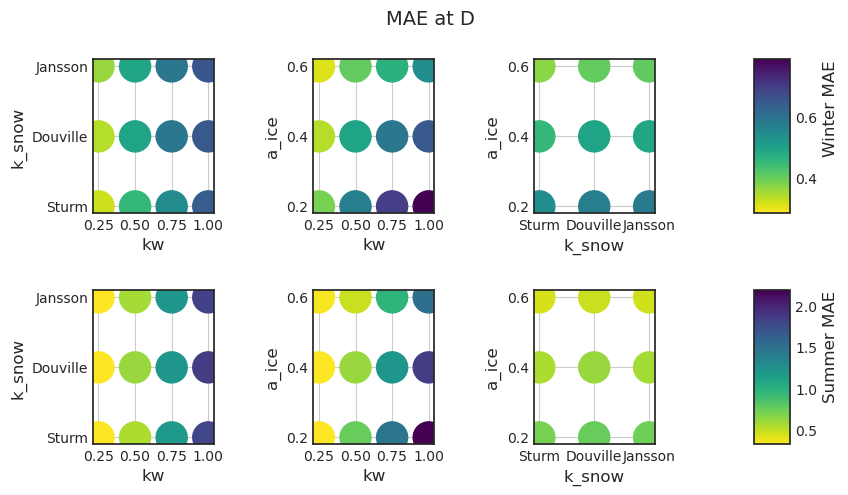

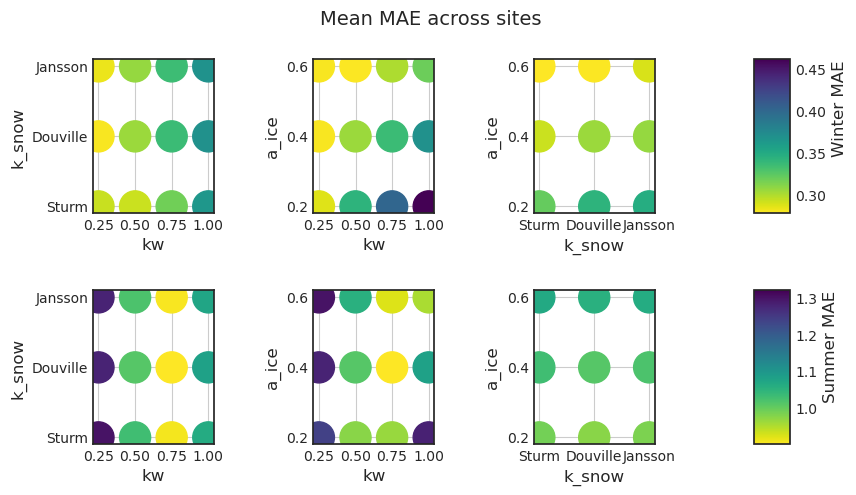

In [243]:
for site in ['AB','B','D','mean']:
    idx = np.where(np.array(['AB','B','D','mean']) == site)[0][0]
    fig, axes = grid_plot(params_dict,summer_result[idx],winter_result[idx])
    if site == 'mean':
        title_first = f'Mean MAE across sites'
    else:
        title_first = f'MAE at {site}'
    if summer_result.shape == (4,4,3,3):
        fig.suptitle(title_first,fontsize=14)
        plt.savefig(f'/home/claire/research/Output/Figs/grid_plot_{site}.png',dpi=200,bbox_inches='tight')
    elif summer_result.shape == (4,3,3):
        fig.suptitle(f'{title_first}\nWith kw=0.25 at D and 1 elsewhere',fontsize=14)
        plt.savefig(f'/home/claire/research/Output/Figs/grid_plot_{site}_nokw.png',dpi=200,bbox_inches='tight')